### Full Name : Ehsan Merrikhi
### Student Number : 400101967


# Support Vector Machines (SVM)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


## Goal
In this assignment, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

In [ ]:
df = pd.read_csv("Liver_Disease.csv")

### Pre-Processing

#### Exploratory Data Analysis:
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

Dataset Shape: (583, 11)
Missing values in each column:
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
label                         0
dtype: int64
Class distribution:
1    416
2    167
Name: label, dtype: int64


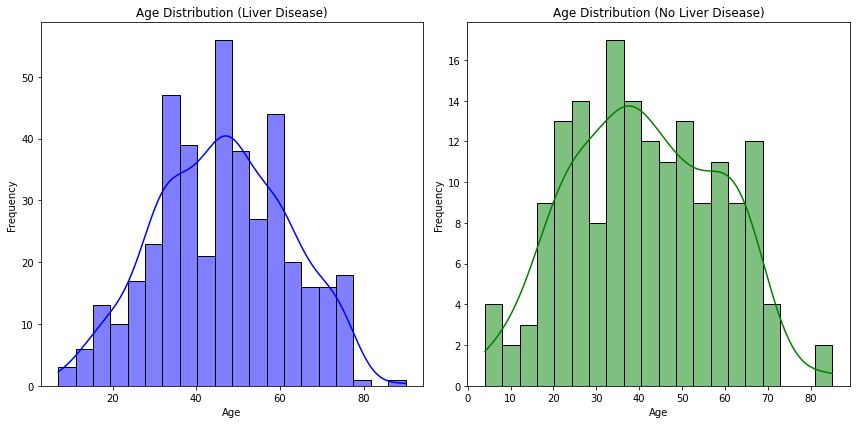

C:\Users\IT CITY\AppData\Local\Temp\ipykernel_1956\3585462560.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=liver_disease, palette='Blues')
C:\Users\IT CITY\AppData\Local\Temp\ipykernel_1956\3585462560.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=no_liver_disease, palette='Greens')


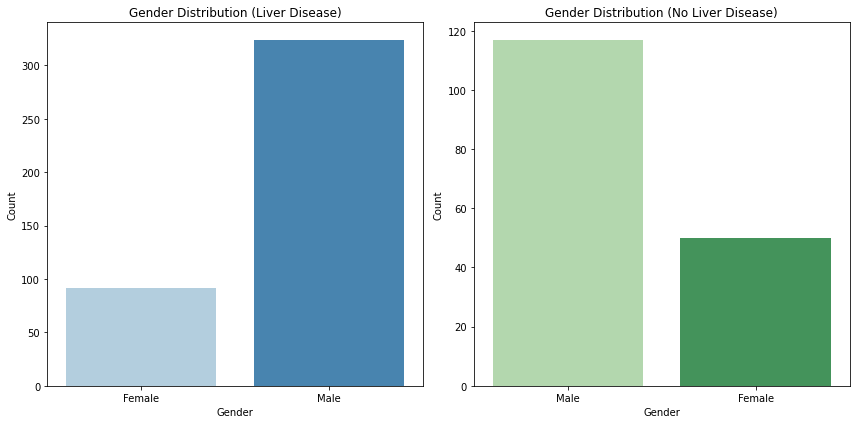

In [ ]:
###############################################################################
## TODO: Find the shape of the dataset.                                      ##
print(f'Dataset Shape: {df.shape}')
###############################################################################


###############################################################################
## TODO: Check if there is missing entries in the dataset columnwise.        ##
print(f'Missing values in each column:\n{df.isnull().sum()}')
###############################################################################

###############################################################################
## TODO: Check whether the dataset is balanced or not.                       ##
print(f"Class distribution:\n{df['label'].value_counts()}")
# we have a balanced dataset

###############################################################################

###############################################################################
## TODO: plot the age distirbution and gender distrbution for both group    ##
## of patients.(4 plots)                                                    ##
# Separate the data into two groups: those with liver disease (label = 1) and those without (label = 2)
liver_disease = df[df['label'] == 1]
no_liver_disease = df[df['label'] == 2]

# Plot Age distribution
plt.figure(figsize=(12, 6))

# Age distribution for patients with liver disease
plt.subplot(1, 2, 1)
sns.histplot(liver_disease['Age'], kde=True, bins=20, color='blue')
plt.title('Age Distribution (Liver Disease)')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Age distribution for patients without liver disease
plt.subplot(1, 2, 2)
sns.histplot(no_liver_disease['Age'], kde=True, bins=20, color='green')
plt.title('Age Distribution (No Liver Disease)')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot Gender distribution
plt.figure(figsize=(12, 6))

# Gender distribution for patients with liver disease
plt.subplot(1, 2, 1)
sns.countplot(x='Gender', data=liver_disease, palette='Blues')
plt.title('Gender Distribution (Liver Disease)')
plt.xlabel('Gender')
plt.ylabel('Count')

# Gender distribution for patients without liver disease
plt.subplot(1, 2, 2)
sns.countplot(x='Gender', data=no_liver_disease, palette='Greens')
plt.title('Gender Distribution (No Liver Disease)')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
###############################################################################


##### Question: What do you conclude from the plots?

From age plots we see our data looks like a gaussian distribution for both patients and non-patients.

From gender plots we see our data is imbalanced in this category and we have way more Male than Female.

#### Outlier Detection & Removal
Check whether we have outliers in the data. If there are, delete them.

In [ ]:
def remove_outliers(df):
    # Define the numeric columns in the dataset for which outliers need to be detected
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

    # Create a copy of the dataframe to avoid modifying the original data
    df_clean = df.copy()

    # For each numeric column, detect and remove outliers based on the IQR
    for col in numeric_columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile) for the column
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1  # Interquartile range

        # Define bounds for outliers (1.5 times the IQR above Q3 and below Q1)
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter the dataset to remove outliers in the current column
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    return df_clean

# Apply the outlier removal function
df_clean = remove_outliers(df)

# Display the shape before and after outlier removal to see the effect
print(f"Original dataset shape: {df.shape}")
print(f"Dataset shape after outlier removal: {df_clean.shape}")


Original dataset shape: (583, 11)
Dataset shape after outlier removal: (327, 11)


#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.
also feel free to do more feature engineering techniques if needed.

In [ ]:
def encode_and_normalize(df):
    # Convert the 'Gender' column into binary (0 for Male, 1 for Female)
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

    # Select only the numerical columns (now including the encoded Gender column)
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

    # Initialize MinMaxScaler to normalize the numerical features
    scaler = MinMaxScaler()

    # Apply the scaler only to the numeric columns
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    return df

# Apply the gender encoding and normalization
df_normalized = encode_and_normalize(df_clean)

# Display the first few rows of the normalized dataset
print(df_normalized.head())

        Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0  0.753086     1.0             0.08          0.000000              0.349296   
3  0.666667     0.0             0.20          0.230769              0.335211   
5  0.518519     0.0             0.52          0.461538              0.408451   
6  0.271605     1.0             0.16          0.076923              0.256338   
7  0.308642     1.0             0.16          0.153846              0.391549   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                  0.086957                    0.123077        0.547170   
3                  0.057971                    0.153846        0.547170   
5                  0.130435                    0.061538        0.698113   
6                  0.086957                    0.030769        0.584906   
7                  0.057971                    0.015385        0.528302   

    Albumin  Albumin_and_Globulin_Ratio  label  
0  0.463415        

### SVM

#### spliting data

In [ ]:
def split_data(df, target_column='label', test_size=0.2, random_state=42):
    # Separate features and the target variable
    X = df.drop(columns=[target_column])  # Features (all columns except the target)
    y = df[target_column]                 # Target variable (label)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

# Apply the split function
X_train, X_test, y_train, y_test = split_data(df_normalized)

# Display the shape of the training and test sets
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training set shape: X_train: (261, 10), y_train: (261,)
Test set shape: X_test: (66, 10), y_test: (66,)


### SVM using Scikit-Learn:
First of all train an svm model with default parameters and report its.

In [ ]:
def train_default_svm(X_train, y_train, X_test, y_test):
    # Initialize the SVM model with default parameters
    svm_model = SVC()

    # Train the model using the training data
    svm_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = svm_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM Accuracy with default parameters: {accuracy * 100:.2f}%")

    return svm_model

# Train and evaluate the SVM model
svm_model = train_default_svm(X_train, y_train, X_test, y_test)

SVM Accuracy with default parameters: 63.64%


#### Grid Search
Use Grid search and validation set to find the best parameters for your SVM model.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def perform_grid_search(X_train, y_train):
    # Define the expanded parameter grid to search over
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000],        # Extended range of regularization parameter
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],    # Extended range of kernel coefficient for RBF
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],  # Added more kernel types
        'degree': [2, 3, 4],                       # Degree for polynomial kernel (only used if 'poly' is selected)
        'coef0': [0.0, 0.1, 0.5, 1],               # Coefficient for 'poly' and 'sigmoid' kernels
    }

    # Initialize the SVM model
    svm_model = SVC()

    # Initialize GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best parameters from grid search
    print(f"Best Parameters: {grid_search.best_params_}")

    # Return the best model from grid search
    return grid_search.best_estimator_

# Perform grid search
best_svm_model = perform_grid_search(X_train, y_train)

# Now we can use the best model to make predictions on the test set
y_pred = best_svm_model.predict(X_test)

# Calculate and print accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy after Grid Search: {accuracy * 100:.2f}%")


Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Best Parameters: {'C': 1000, 'coef0': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'sigmoid'}
SVM Accuracy after Grid Search: 62.12%


Train an svm model on the entire training data using the parameters you found in the previous step.

In [ ]:
def train_best_svm(X_train, y_train, X_test, y_test, best_params):
    # Initialize the SVM model with the best parameters found in the grid search
    svm_model = SVC(**best_params)

    # Train the model on the entire training data
    svm_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = svm_model.predict(X_test)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM Accuracy with Best Parameters: {accuracy * 100:.2f}%")

    return svm_model

# Assume best_params has been retrieved from the grid search step
best_params = best_svm_model.get_params()  # You can retrieve the best parameters like this

# Train the SVM model using the best parameters
trained_svm_model = train_best_svm(X_train, y_train, X_test, y_test, best_params)

SVM Accuracy with Best Parameters: 62.12%


### Confusion Matrix
Plot the confusion matrix and report the model accuracy on test set.
What does each entry of the confusion matrix mean?

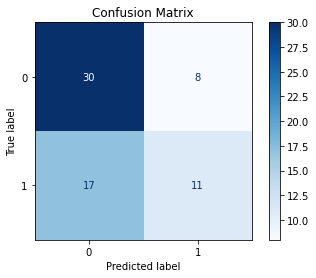

Model Accuracy: 62.12%


In [ ]:
def plot_confusion_matrix(y_test, y_pred):
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Assuming 'trained_svm_model' is the model we have trained and tested
y_pred = trained_svm_model.predict(X_test)

# Plot the confusion matrix and print accuracy
plot_confusion_matrix(y_test, y_pred)


Add some outliers to the dataset, train an SVM and logistic regression model, and compare the results.

In [ ]:
def add_outliers(X_train, y_train, num_outliers=10):
    """
    Adds outliers to the dataset by injecting random noise into some training samples.
    """
    # Generate random outlier values
    np.random.seed(42)
    outliers = np.random.uniform(low=-10, high=10, size=(num_outliers, X_train.shape[1]))

    # Assign random labels to these outliers (randomly 0 or 1 for binary classification)
    outlier_labels = np.random.choice(y_train.unique(), size=num_outliers)

    # Append the outliers to the original dataset
    X_train_with_outliers = np.vstack([X_train, outliers])
    y_train_with_outliers = np.hstack([y_train, outlier_labels])

    return X_train_with_outliers, y_train_with_outliers

# Add outliers to the dataset
X_train_with_outliers, y_train_with_outliers = add_outliers(X_train, y_train)

# Train an SVM model on the data with outliers
svm_model_with_outliers = SVC()
svm_model_with_outliers.fit(X_train_with_outliers, y_train_with_outliers)

# Train a Logistic Regression model on the data with outliers
log_reg_model_with_outliers = LogisticRegression(max_iter=1000)
log_reg_model_with_outliers.fit(X_train_with_outliers, y_train_with_outliers)

# Evaluate both models on the test set
svm_pred_with_outliers = svm_model_with_outliers.predict(X_test)
log_reg_pred_with_outliers = log_reg_model_with_outliers.predict(X_test)

# Calculate and print accuracies for both models
svm_accuracy_with_outliers = accuracy_score(y_test, svm_pred_with_outliers)
log_reg_accuracy_with_outliers = accuracy_score(y_test, log_reg_pred_with_outliers)

print(f"SVM Accuracy with Outliers: {svm_accuracy_with_outliers * 100:.2f}%")
print(f"Logistic Regression Accuracy with Outliers: {log_reg_accuracy_with_outliers * 100:.2f}%")


SVM Accuracy with Outliers: 57.58%
Logistic Regression Accuracy with Outliers: 54.55%


c:\Users\IT CITY\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\IT CITY\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
